<a href="https://colab.research.google.com/github/elifgularslan/AISigner/blob/main/AnimalClassificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# 1. KÜTÜPHANELER VE AYARLAR
# ==========================================
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, callbacks,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomFlip, RandomContrast, GaussianNoise, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

# Uyarıları sessize al
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print(f"TensorFlow Versiyonu: {tf.__version__}")

# Görüntü Boyutları (Senin istediğin gibi büyük boyut)
IMG_SIZE = 224
BATCH_SIZE = 32

TensorFlow Versiyonu: 2.19.0


In [ ]:
# ==========================================
# 2. VERİ SETİNİ İNDİRME VE HAZIRLAMA (PIPELINE)
# ==========================================
print("\n📥 Oxford-IIIT Pet Veri Seti İndiriliyor (37 Irk)...")
(train_ds, test_ds), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names
print(f"✅ Veri Seti Hazır! Toplam {num_classes} Sınıf Var.")

# Ön İşleme Fonksiyonu
def preprocess(image, label):
    # 1. Resmi Boyutlandır
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # 2. 0-1 Arasına Sıkıştır (Normalize)
    image = image / 255.0
    # 3. Etiketi One-Hot Formatına Çevir (Categorical Crossentropy için şart)
    label = tf.one_hot(label, num_classes)
    return image, label

# Veri Hattını (Pipeline) Hızlandırma
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)


📥 Oxford-IIIT Pet Veri Seti İndiriliyor (37 Irk)...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.SEAMAO_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.SEAMAO_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
✅ Veri Seti Hazır! Toplam 37 Sınıf Var.



👀 Gelişmiş Augmentation Etkileri Görselleştiriliyor...


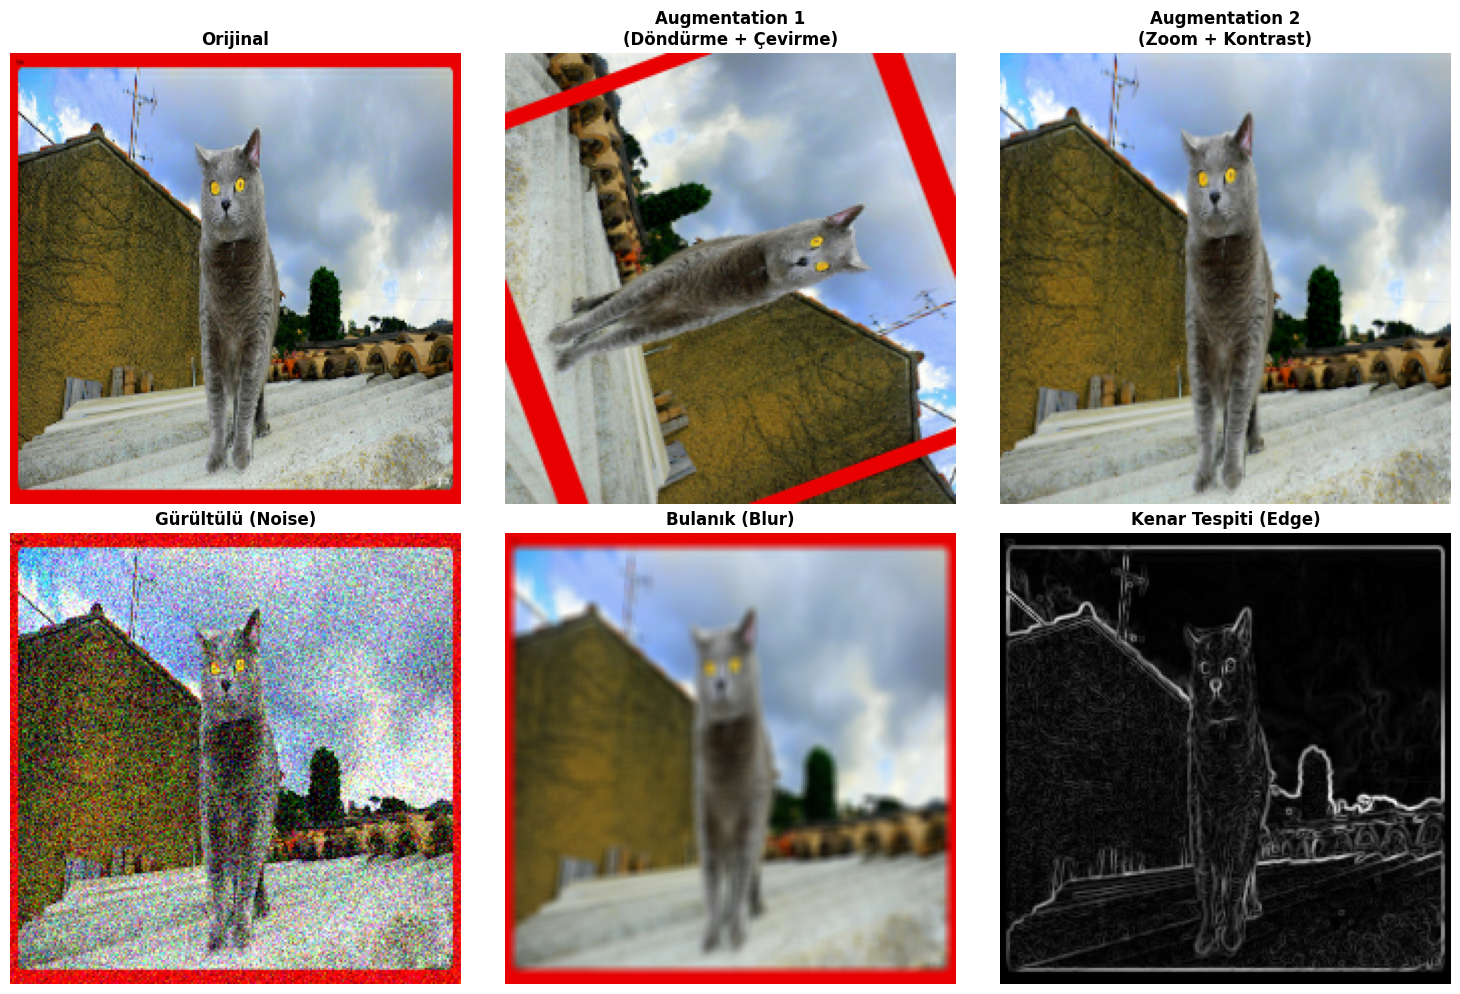

In [ ]:
# 3. DETAYLI AUGMENTATION GÖRSELLEŞTİRME (SENİN KODUN)
# ==========================================
print("\n👀 Gelişmiş Augmentation Etkileri Görselleştiriliyor...")

def get_edges(image_tensor):
    # Kenar Tespiti (Sobel Filtresi ile)
    image_tensor = tf.expand_dims(image_tensor, 0)
    gray = tf.image.rgb_to_grayscale(image_tensor)
    sobel = tf.image.sobel_edges(gray)
    magnitude = tf.sqrt(tf.reduce_sum(tf.square(sobel), axis=-1))
    return magnitude[0, ..., 0]

def get_blur(image_tensor):
    # Bulanıklaştırma
    image_tensor = tf.expand_dims(image_tensor, 0)
    blurred = tf.nn.avg_pool2d(image_tensor, ksize=5, strides=1, padding='SAME')
    return blurred[0]

# 1. Eğitim setinden 1 paket (batch) çek
for image_batch, label_batch in train_dataset.take(1):
    original_img = image_batch[0]

# 2. Efekt Katmanlarını Tanımla (Senin importlarına uygun hale getirildi)
aug_geo_1 = Sequential([RandomRotation(0.2), RandomFlip("horizontal")])
aug_geo_2 = Sequential([RandomZoom(0.3), RandomContrast(0.4)])
noise_layer = GaussianNoise(0.15) # Görselde belli olsun diye yüksek

# 3. Resimleri Oluştur
img_orig = original_img
img_aug1 = aug_geo_1(tf.expand_dims(original_img, 0), training=True)[0]
img_aug2 = aug_geo_2(tf.expand_dims(original_img, 0), training=True)[0]
img_noise = noise_layer(tf.expand_dims(original_img, 0), training=True)[0]
img_blur = get_blur(original_img)
img_edge = get_edges(original_img)

# 4. 6'lı Izgara Çizdir
plt.figure(figsize=(15, 10))
titles = ["Orijinal", "Augmentation 1\n(Döndürme + Çevirme)",
          "Augmentation 2\n(Zoom + Kontrast)", "Gürültülü (Noise)",
          "Bulanık (Blur)", "Kenar Tespiti (Edge)"]
images = [img_orig, img_aug1, img_aug2, img_noise, img_blur, img_edge]

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.title(titles[i], fontsize=12, fontweight='bold')
    if i == 5:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(tf.clip_by_value(images[i], 0.0, 1.0))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# 4. MODEL VE EĞİTİM (BURASI ANA KISIM)
# ==========================================
print("\n🧠 Model İnşa Ediliyor (Modern Mimari: GlobalAveragePooling)...")

try:
    act_func = tf.keras.activations.mish
except:
    act_func = 'relu'

# L2 Regularization Ayarı (Aşırı öğrenmeyi matematiksel olarak baskılar)
reg = regularizers.l2(0.001)

model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # --- AUGMENTATION (Daha Yumuşak) ---
    # Model rahat öğrensin diye oranları 0.1'den 0.05'e çektik
    RandomRotation(0.05),
    RandomZoom(0.05),
    RandomFlip("horizontal"),
    RandomContrast(0.1),

    # Noise (CV için şart)
    GaussianNoise(0.02),

    # --- CNN KATMANLARI (Kapasite Artırıldı) ---
    # Blok 1 (64 Filtre) - Başlangıç kapasitesini artırdık
    Conv2D(64, (3, 3), padding='same', activation=act_func, kernel_regularizer=reg),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    # Blok 2 (128 Filtre)
    Conv2D(128, (3, 3), padding='same', activation=act_func, kernel_regularizer=reg),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Blok 3 (256 Filtre)
    Conv2D(256, (3, 3), padding='same', activation=act_func, kernel_regularizer=reg),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    # Blok 4 (512 Filtre) - Derin özellikleri yakalar
    Conv2D(512, (3, 3), padding='same', activation=act_func, kernel_regularizer=reg),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # Burada Dropout yok

    # --- KRİTİK DEĞİŞİKLİK: GAP ---
    # Flatten yerine GlobalAveragePooling2D kullanıyoruz.
    # Bu katman resmi 14x14x512'den direkt 512 uzunluğunda bir vektöre çevirir.
    # 12 Milyon parametre yerine sadece 200-300 bin parametre olur.
    # Model daha zor ezberler ama DAHA İYİ GENELLER.
    GlobalAveragePooling2D(),

    # Sınıflandırma
    Dense(512, activation=act_func, kernel_regularizer=reg),
    BatchNormalization(),
    Dropout(0.5),

    # Çıkış
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001), # GAP kullandığımız için başlangıç hızını artırabiliriz
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


🧠 Model İnşa Ediliyor (Modern Mimari: GlobalAveragePooling)...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 224, 224, 3)    │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 1,838,501 (7.01 MB)

 Trainable params: 1,835,557 (7.00 MB)

 Non-trainable params: 2,944 (11.50 KB)


🚀 Eğitim Başlıyor (Noise Injection ile)...
Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 80s 592ms/step - accuracy: 0.0363 - loss: 5.8696 - val_accuracy: 0.0237 - val_loss: 6.0589 - learning_rate: 0.0010
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 507ms/step - accuracy: 0.0537 - loss: 5.3293 - val_accuracy: 0.0248 - val_loss: 6.5997 - learning_rate: 0.0010
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 508ms/step - accuracy: 0.0545 - loss: 5.0925 - val_accuracy: 0.0333 - val_loss: 5.5859 - learning_rate: 0.0010
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 508ms/step - accuracy: 0.0650 - loss: 4.8428 - val_accuracy: 0.0398 - val_loss: 5.5727 - learning_rate: 0.0010
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 71s 596ms/step - accuracy: 0.0683 - loss: 4.5946 - val_accuracy: 0.0390 - val_loss: 4.5926 - learning_rate: 0.0010
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 509ms/step - accuracy: 0.0815 - loss: 4.4237 - val_accuracy: 0.0570 - val_loss: 4.4104 - learning_rate: 0.0010
Epoch 7/40
115/115 ━━━━━━━

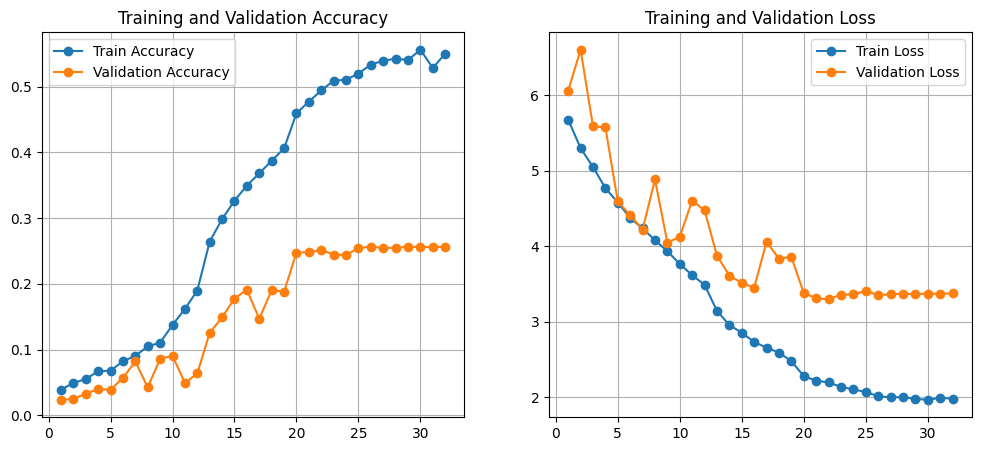

115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.2585 - loss: 3.2649
🎯 Final Test Doğruluğu: %25.16


In [ ]:
# --- CALLBACKS (AKILLI EĞİTİM) ---
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1
)

# --- EĞİTİM BAŞLIYOR ---
print("\n🚀 Eğitim Başlıyor (Noise Injection ile)...")
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=40,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
# --- SONUÇLARI ÇİZDİR ---
print("\n📊 Grafikler Çiziliyor...")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Final Skoru Yazdır
loss, accuracy = model.evaluate(test_dataset)
print(f"🎯 Final Test Doğruluğu: %{accuracy*100:.2f}")
# --- MODELİ KAYDET ---
model.save('oxford_pets_final.keras')
